*Ewing et al (2020) Structural variants at the BRCA1/2 loci are a common source of homologous repair deficiency in high grade serous ovarian carcinoma*

# Notebook 9a - Multivariable modelling dataset preparation and output visualisation

This notebook contains the code to prepare the two datasets for multivariable modelling and to visualise the results of the output.

# Prepare datasets

## Prepare dataset for full model

### Genomic variables

In [ ]:
sampleInfo<-read.table("Dataset_for_lasso_regression.txt",sep="\t",header=T,stringsAsFactors=F)
rownames(sampleInfo)<-sampleInfo[,1]

loh<-read.table("LOH_status.txt",sep="\t",header=T)

sampleInfo<-merge(sampleInfo,loh,by="Sample")
sampleInfo$HRDeficient<-ifelse(sampleInfo$HRDetect>0.7,1,0)

In [2]:
sampleInfo[sampleInfo$BRCA1status_compound=="Excluded","BRCA1status_compound"]<-"None"
sampleInfo$BRCA1status_compound<-relevel(as.factor(sampleInfo$BRCA1status_compound),ref="None")

sampleInfo[sampleInfo$BRCA2status_compound=="Excluded","BRCA2status_compound"]<-"None"
sampleInfo$BRCA2status_compound<-relevel(as.factor(sampleInfo$BRCA2status_compound),ref="None")

sampleInfo[is.na(sampleInfo$Double_del),"Double_del"]<-"None"
sampleInfo$Double_del<-relevel(as.factor(sampleInfo$Double_del),ref="None")

sampleInfo$BRCA1_LOH<-relevel(as.factor(sampleInfo$BRCA1_LOH),ref="0")
sampleInfo$BRCA2_LOH<-relevel(as.factor(sampleInfo$BRCA2_LOH),ref="0")

In [3]:
hr_sv_loads<-read.csv("SuppTable_HR_SV_loads_sample_type.csv")
hr_sv_loads[is.na(hr_sv_loads$Large_consensus_DEL),"Large_consensus_DEL"]<-0
hr_sv_loads$hr_largedel_pres<-ifelse(hr_sv_loads$Large_consensus_DEL==0,1,0)
hr_sv_loads<-hr_sv_loads[,c("Sample","hr_largedel_pres","Large_consensus_DEL")]

In [4]:
hr_snv_loads<-read.table("nonBRCAHR_SNV_loads.txt")
colnames(hr_snv_loads)<-c("nonBRCA_SNV_load","Sample")

hr_loads<-merge(hr_sv_loads,hr_snv_loads,by="Sample",all.x=T)
hr_loads[is.na(hr_loads$nonBRCA_SNV_load),"nonBRCA_SNV_load"]<-0

sampleInfo2<-merge(sampleInfo,hr_loads,by="Sample")
rownames(sampleInfo2)<-as.character(sampleInfo2$Sample)

In [6]:
sampleInfo_analysis<-sampleInfo2[,c("BRCA1_Germline_SNV",'BRCA1_Somatic_SNV',
                            'BRCA1_LOF', 'BRCA2_Germline_SNV', 'BRCA2_Somatic_SNV', 'BRCA2_LOF','BRCA1_LOH','BRCA2_LOH',
                            'BRCA1_INV_SPAN', 'BRCA2_COPY_GAIN', 'BRCA1status_compound', 'BRCA2status_compound',
                            'Double_del','BRCA1_pro_meth', 'non_BRCA_Somatic_SNV', 'non_BRCA_Germline_SNV',
                            'Mutational_load', 'SV_load', 'CNV_load', 
                            'hr_largedel_pres', 'Large_consensus_DEL', 'nonBRCA_SNV_load',
                            'WGD', 
                            'Cellularity',"Cohort",
                            'BRCA1_VST','BRCA2_VST',
                            'HRDeficient'
)]
rownames(sampleInfo_analysis)<-as.character(sampleInfo2$Sample)

In [7]:
sampleInfo_analysis[sampleInfo_analysis$BRCA1status_compound=="SNV + deletions (both genes)",
 "BRCA1status_compound"]<-"SNV + deletion (same gene)"
sampleInfo_analysis[sampleInfo_analysis$BRCA1status_compound=="SNV + deletion (other gene)",
 "BRCA1status_compound"]<-"None"
sampleInfo_analysis[sampleInfo_analysis$BRCA2status_compound=="SNV + deletions (both genes)",
 "BRCA2status_compound"]<-"SNV + deletion (same gene)"
sampleInfo_analysis[sampleInfo_analysis$BRCA2status_compound=="SNV + deletion (other gene)",
 "BRCA2status_compound"]<-"None"

sampleInfo_analysis[,c(1:16,20,23,25)]<-apply(sampleInfo_analysis[,c(1:16,20,23,25)],2,as.factor)
sampleInfo_analysis$Double_del<-relevel(as.factor(sampleInfo_analysis$Double_del),ref="None")
sampleInfo_analysis$Cohort<-relevel(as.factor(sampleInfo_analysis$Cohort),ref="AO")

### HRD ground truth for DE expression signature

In [8]:
hrdef<-read.table("SHGSOC_withBRCASNVs.txt",sep="\t")
hrdef<-as.character(hrdef[,1])

hrprof<-read.table("Likely_HRproficient_samples.txt",sep="\t")
hrprof<-as.character(hrprof[,1])

### Transcriptomic variables

In [ ]:
library(tximport)
require(DESeq2)

In [38]:
files_scot<-dir("SHGSOC/salmon",pattern="quant.sf",recursive = T,full.names = TRUE)
files_aocs<-dir("AOCS/salmon",pattern="quant.sf",recursive = T,full.names = TRUE)
files_tcga<-dir("TCGA/salmon",pattern="quant.sf",recursive = T,full.names = TRUE)
files<-c(files_scot,files_aocs,files_tcga)

rna_reps_to_exclude<-read.table("RNAseq_replicates_forexclusion.txt",sep="\t")
rna_reps_to_exclude<-as.character(rna_reps_to_exclude[,1])

new_files_orig<-setdiff(files,rna_reps_to_exclude)
tx2knownGene <- read.csv("tx2gene.csv",header = F)

names(new_files_orig)[1:37]<-do.call("cbind",strsplit(new_files_orig[1:37],split = "[/.]"))[10,]
names(new_files_orig)[38:42]<-do.call("cbind",strsplit(new_files_orig[38:42],split = "[/.]"))[10,]
names(new_files_orig)[43:122]<-do.call("cbind",strsplit(new_files_orig[43:122],split = "[/.]"))[6,]
names(new_files_orig)[123:152]<-do.call("cbind",strsplit(new_files_orig[123:152],split = "[/.]"))[10,]

txi.salmon <- tximport(new_files_orig, type = "salmon", tx2gene = tx2knownGene)

reading in files with read_tsv
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 
summarizing abundance
summarizing counts
summarizing length


In [ ]:
sample<-read.table("SampleInformation.txt",sep="\t",header=T,stringsAsFactors=F)
sample_expr<-sample

rna_sampleids<-colnames(head(txi.salmon2$counts))
rna_short_sampleids<-rep(NA,length(rna_sampleids))
rna_short_sampleids[1:42]<-substr(rna_sampleids[1:42],1,9)
rna_short_sampleids[43:122]<-substr(rna_sampleids[43:122],1,8)
rna_short_sampleids[123:152]<-substr(rna_sampleids[123:152],1,7)
rna<-data.frame(RNA_sample=rna_sampleids,Sample=rna_short_sampleids)
rna<-rna[as.character(rna$Sample) %in% as.character(sample_expr$Sample),]

new_files<-new_files_orig[as.character(rna$RNA_sample)]

txi.salmon2 <- tximport(new_files, type = "salmon", tx2gene = tx2knownGene)

In [ ]:
coldata<-merge(rna,sample_expr,by="Sample",all.x=T)

coldata$HRDtruth<-"Excluded"
coldata[(coldata$Sample %in% hrdef),"HRDtruth"]<-"HRDef"
coldata[(coldata$Sample %in% hrprof),"HRDtruth"]<-"HRProf"

coldata$Cohort<-substr(as.character(coldata$Sample),1,2)

rownames(coldata)<-as.character(coldata$RNA_sample)

coldata[is.na(coldata$BRCA1status),"BRCA1status"]<-"Excluded"
coldata[is.na(coldata$BRCA2status),"BRCA2status"]<-"Excluded"

coldata<-coldata[as.character(rna$RNA_sample),]
coldata$condition<-factor(coldata$HRDtruth)
rownames(coldata)<-c(1:150)

dds <- DESeqDataSetFromTximport(txi.salmon2, 
                               colData = coldata,
                                design=~Cohort+Purity+condition)

dds_correct <- DESeqDataSetFromTximport(txi.salmon2, 
                               colData = coldata,
                                design=~as.factor(Cohort)+Purity)  

dds_correct <- DESeq(dds_correct)
vsd <- vst(dds_correct , blind=FALSE)

sampleInfo_analysis[sampleInfo_analysis$HRDeficient=='1',"HRDeficient"]<-
                    "HRD"
sampleInfo_analysis[sampleInfo_analysis$HRDeficient=='0',"HRDeficient"]<-
                    "HRP"
sampleInfo_analysis$HRDeficient<-as.factor(sampleInfo_analysis$HRDeficient)
sampleInfo_analysis$HRDeficient<-relevel(as.factor(sampleInfo_analysis$HRDeficient),ref="HRP")

In [15]:
save.image(file="Robjecttosetup_multivariablemodel_full.RData")

See notebook 9a for full modelling code over multiple partitions of the data.

## Prepare dataset for reduced genomic model

### Genomic variables

In [37]:
sampleInfo<-read.table("Dataset_for_elastic_regression_genomic.txt",sep="\t",header=T,stringsAsFactors=F)
rownames(sampleInfo)<-sampleInfo[,1]

loh<-read.table("LOH_status.txt",sep="\t",header=T)
sampleInfo<-merge(sampleInfo,loh,by="Sample")
sampleInfo$HRDeficient<-ifelse(sampleInfo$HRDetect>0.7,1,0)

In [38]:
sampleInfo[sampleInfo$BRCA1status_compound=="Excluded","BRCA1status_compound"]<-"None"
sampleInfo$BRCA1status_compound<-relevel(as.factor(sampleInfo$BRCA1status_compound),ref="None")

sampleInfo[sampleInfo$BRCA2status_compound=="Excluded","BRCA2status_compound"]<-"None"
sampleInfo$BRCA2status_compound<-relevel(as.factor(sampleInfo$BRCA2status_compound),ref="None")


sampleInfo[is.na(sampleInfo$Double_del),"Double_del"]<-"None"
sampleInfo$Double_del<-relevel(as.factor(sampleInfo$Double_del),ref="None")

sampleInfo$BRCA1_LOH<-relevel(as.factor(sampleInfo$BRCA1_LOH),ref="0")
sampleInfo$BRCA2_LOH<-relevel(as.factor(sampleInfo$BRCA2_LOH),ref="0")

In [39]:
sampleInfo_analysis<-sampleInfo[,c("BRCA1_Germline_SNV",'BRCA1_Somatic_SNV',
                            'BRCA1_LOF', 'BRCA2_Germline_SNV', 'BRCA2_Somatic_SNV', 'BRCA2_LOF',
                            'BRCA1_INV_SPAN', 'BRCA2_COPY_GAIN', 'BRCA1status_compound', 'BRCA2status_compound',
                            'Double_del','BRCA1_pro_meth','BRCA1_LOH','BRCA2_LOH',
                            'Mutational_load', 'SV_load', 'CNV_load', 'WGD', 
                            'Cellularity',"Cohort",
                            'HRDeficient'

)]
rownames(sampleInfo_analysis)<-as.character(sampleInfo$Sample)

In [40]:
sampleInfo_analysis[sampleInfo_analysis$BRCA1status_compound=="SNV + deletions (both genes)",
 "BRCA1status_compound"]<-"SNV + deletion (same gene)"
sampleInfo_analysis[sampleInfo_analysis$BRCA1status_compound=="SNV + deletion (other gene)",
 "BRCA1status_compound"]<-"None"
sampleInfo_analysis[sampleInfo_analysis$BRCA2status_compound=="SNV + deletions (both genes)",
 "BRCA2status_compound"]<-"SNV + deletion (same gene)"
sampleInfo_analysis[sampleInfo_analysis$BRCA2status_compound=="SNV + deletion (other gene)",
 "BRCA2status_compound"]<-"None"

sampleInfo_analysis[,c(1:14,18,20,21)]<-apply(sampleInfo_analysis[,c(1:14,18,20,21)],2,as.factor)
sampleInfo_analysis$Double_del<-relevel(as.factor(sampleInfo_analysis$Double_del),ref="None")
sampleInfo_analysis$Cohort<-relevel(as.factor(sampleInfo_analysis$Cohort),ref="AO")

sampleInfo_analysis[sampleInfo_analysis$HRDeficient=='1',"HRDeficient"]<-
                    "HRD"
sampleInfo_analysis[sampleInfo_analysis$HRDeficient=='0',"HRDeficient"]<-
                    "HRP"
sampleInfo_analysis$HRDeficient<-as.factor(sampleInfo_analysis$HRDeficient)
sampleInfo_analysis$HRDeficient<-relevel(as.factor(sampleInfo_analysis$HRDeficient),ref="HRP")

In [41]:
save.image(file="Robjecttosetup_reducedmultivariablemodel.RData")

# Visualise output from multivariable models

## Full model with expression N=150

In [1]:
features<-c(BRCA1_Germline_SNV1="BRCA1 germline SNV/indel",
            HRD_DE_sig="HRD expression signature",
            `BRCA2status_compoundSNV + deletion (same gene)`="\nBRCA2 SNV and deletion\nat same gene\n",
            BRCA1_pro_meth1="BRCA1 promoter methylation",
            SNV_load="SNV load",
            BRCA1_Somatic_SNV1="BRCA1 somatic SNV/indel",
            `Double_delDouble deletion`="Double deletion",
            BRCA2_Germline_SNV1="BRCA2 germline SNV/indel",
            CNV_load="Large CNV load",
            BRCA2_Somatic_SNV1="BRCA2 somatic SNV/indel",
            BRCA1_VST="BRCA1 expression",
            BRCA1_INV_SPAN1="BRCA1 inversion",
            BRCA2_LOF1="BRCA2 deletion",
            CohortDO="Cohort - TCGA",
            CohortSH="Cohort - SHGSOC",
            Mutational_load="SNV load",
            `BRCA1status_compoundSNV + deletion (same gene)`="BRCA1 short variant + deletion\nat same gene",
            BRCA2_COPY_GAIN1="BRCA2 copy gain",
            BRCA1_LOF1="BRCA1 deletion",
            hr_largedel_pres1="Presence of large deletion at HR gene",
            SV_load="SV load",
            WGD1="Whole genome doubling",
            Cellularity="Tumour cellularity",
            nonBRCA_SNV_load="SNV load at HR genes",
            Large_consensus_DEL="Large deletion load at HR genes",
            non_BRCA_Somatic_SNV1="Somatic SNV/indel at HR gene",
            non_BRCA_Germline_SNV1="Germline SNV/indel at HR gene",
            BRCA2_VST="BRCA2 expression",
            BRCA1_LOH1="BRCA1 LOH",
            BRCA2_LOH1="BRCA2 LOH"
)

### Load model output

In [24]:
load("df_1_50_loh_full_names.RData")
s<-apply(df2[,-1],1,function(x) sum(x==0))
df2<-df2[s!=100 & df2$Feature!="(Intercept)",]  
feature_medians<-apply(df2[,-1],1,median)
feature_medians_abs<-apply(df2[,-1],1,function(x) abs(median(x)))
    
col<-character(length(feature_medians_abs))
col<- ifelse(feature_medians_abs>0,"red","black")
df2<-data.frame(df2,Col=col)
    
feature_medians<-data.frame(Feature=df2$Feature,Median=feature_medians)

feature_medians$Median<-as.numeric(as.character(feature_medians$Median))
feat_ord<-feature_medians[order(feature_medians$Median,decreasing=T),"Feature"]

### Forest plot of estimates across data partitions

In [ ]:
library(reshape)
library(ggplot2)
library(gridExtra)

long.df2<-melt(df2,id.vars=c("Feature","Col"))
long.df2$Feature<-factor(long.df2$Feature,levels=rev(feat_ord))

options(repr.plot.width=10)
gg_stab<-ggplot(long.df2,aes(x=Feature,y=value,colour=Col))+
        geom_boxplot(outlier.shape=NA)+
        geom_jitter(width=0.1)+
        coord_flip()+
        theme_bw()+
        scale_x_discrete(labels=features)+
        ylab("Effect size (log odds)")+
        scale_colour_manual(values=c("black","red"))+
        theme(legend.position="None")+
        ylim(-4,4)

### Bar plot of median effect size

In [26]:
feature_medians<-feature_medians[feature_medians$Median!=0,]

feature_medians$Feature<-factor(feature_medians$Feature,levels=feature_medians[order(feature_medians$Median,decreasing=F),"Feature"])
     
options(repr.plot.height=7,repr.plot.width=6)

gg_median<-ggplot(feature_medians,aes(x=Feature,y=Median))+
    geom_bar(stat="identity",alpha=0.4)+
    coord_flip()+
    theme_bw()+
    ylab("Median effect size (log odds)")+
    scale_x_discrete(labels=features)

### Combine plots

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

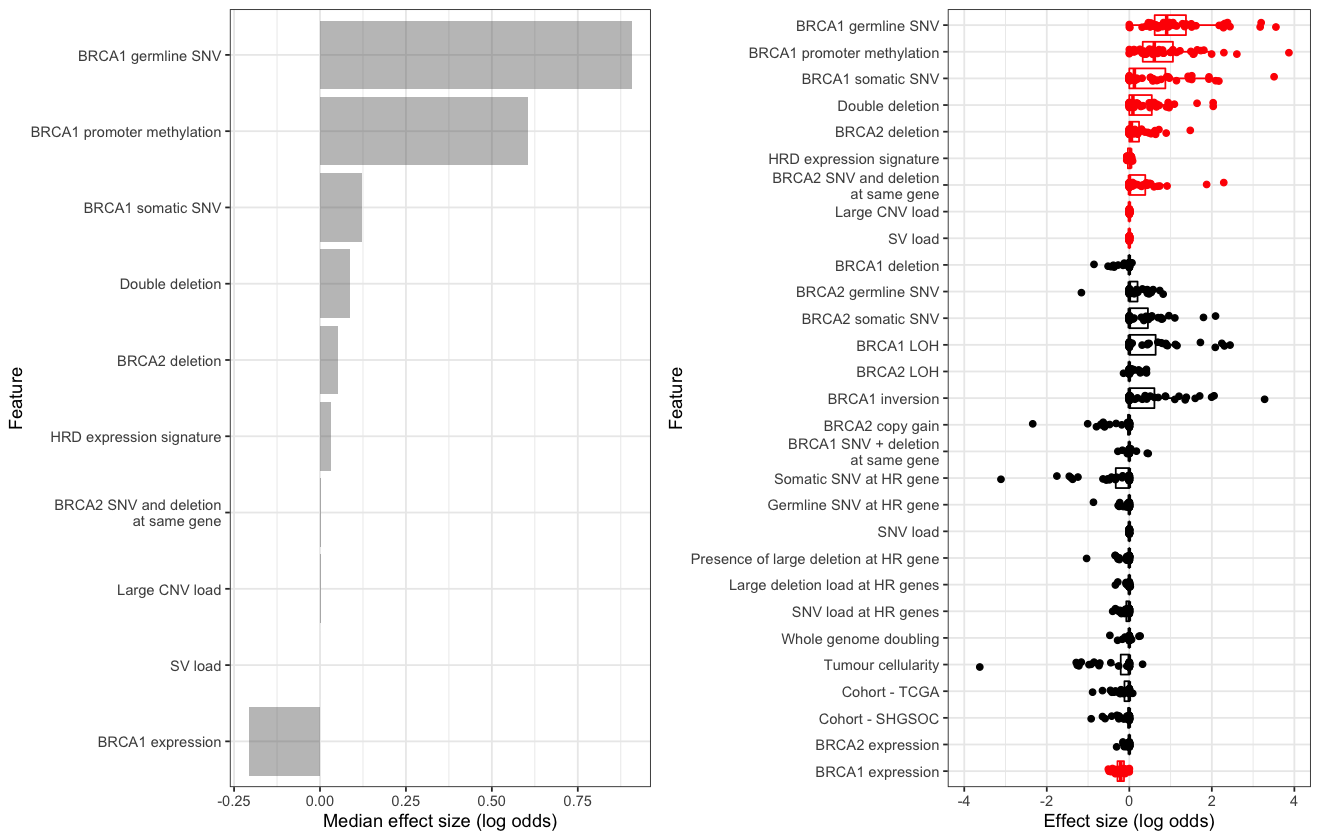

In [31]:
options(repr.plot.height=7,repr.plot.width=11)
    grid.arrange(gg_median,gg_stab,nrow=1)


## Genomic modelling on larger dataset - maximise power

### Load model output

In [2]:
load("reduced_df_1_100_loh.RData")
s<-apply(df2[,-1],1,function(x) sum(x==0))
df2<-df2[s!=100 & df2$Feature!="(Intercept)",]  
feature_medians<-apply(df2[,-1],1,median)
feature_medians_abs<-apply(df2[,-1],1,function(x) abs(median(x)))
    
col<-character(length(feature_medians_abs))
col<- ifelse(feature_medians_abs>0,"red","black")
df2<-data.frame(df2,Col=col)
    
feature_medians<-data.frame(Feature=df2$Feature,Median=feature_medians)

feature_medians$Median<-as.numeric(as.character(feature_medians$Median))
feat_ord<-feature_medians[order(feature_medians$Median,decreasing=T),"Feature"]

### Forest plot of estimates across data partitions

In [ ]:
long.df2<-melt(df2,id.vars=c("Feature","Col"))
long.df2$Feature<-factor(long.df2$Feature,levels=rev(feat_ord))

options(repr.plot.width=10)
gg_stab<-ggplot(long.df2,aes(x=Feature,y=value,colour=Col))+
        geom_boxplot(outlier.shape=NA)+
        geom_jitter(width=0.1)+
        coord_flip()+
        theme_bw()+
        scale_x_discrete(labels=features)+
        ylab("Effect size (log odds)")+
        scale_colour_manual(values=c("black","red"))+
        theme(legend.position="None")+
        ylim(-4,4)

### Bar plot of median effect size

In [4]:
feature_medians<-feature_medians[feature_medians$Median!=0,]
feature_medians$Feature<-factor(feature_medians$Feature,levels=feature_medians[order(feature_medians$Median,decreasing=F),"Feature"])
                    
options(repr.plot.height=7,repr.plot.width=6)
gg_median<-ggplot(feature_medians,aes(x=Feature,y=Median))+
    geom_bar(stat="identity",alpha=0.4)+
    coord_flip()+
    theme_bw()+
    ylab("Median effect size (log odds)")+
    scale_x_discrete(labels=features)

### Combine plots

Warning message:
“Removed 27 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 27 rows containing missing values (geom_point).”

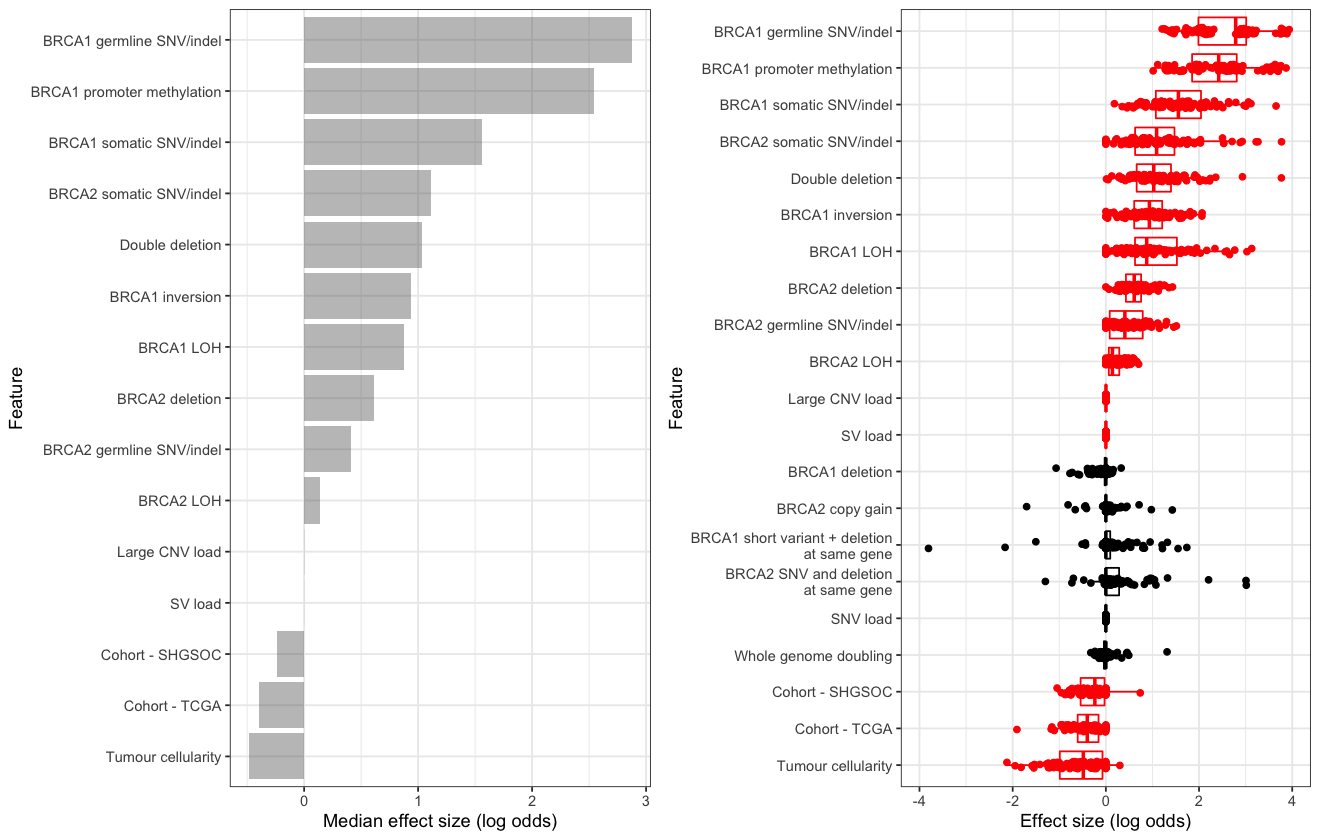

In [9]:
options(repr.plot.height=7,repr.plot.width=11)
grid.arrange(gg_median,gg_stab,nrow=1)